In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
torch.manual_seed(0)
import numpy as np
import matplotlib.pyplot as plt

from synthpop.infer import Infer, VI 

In [4]:
def model(generator):
    n_agents = 1000
    agent_ages, agent_sexes = generator(n_agents)
    mask = agent_sexes == 0.
    return agent_ages[mask], agent_ages[~mask]

def loss(x):
    age_males, age_females = x
    return torch.abs(1 - torch.abs(torch.mean(age_males) - torch.mean(age_females)))

class MetaGenerator(torch.nn.Module):
    def __init__(self, params):
        super().__init__()
        self._params = [torch.nn.Parameter(params), torch.nn.Parameter(torch.eye(2))]

    def clamp_sigma(self):
        sigma = self._params[1].clone()
        mask = torch.eye(sigma.shape[0], device=sigma.device).bool()
        sigma[mask] = torch.clamp(sigma[mask], min=1e-3)
        return sigma

    def sample(self, n_samples):
        sigma = torch.mm(self._params[1], self._params[1].t())
        dist = torch.distributions.MultivariateNormal(self._params[0], sigma)
        samples = dist.rsample((n_samples,))
        return samples, dist.log_prob(samples)

    def log_prob(self, x):
        #sigma = self.clamp_sigma()
        sigma = torch.mm(self._params[1], self._params[1].t())
        dist = torch.distributions.MultivariateNormal(self._params[0], sigma)
        return dist.log_prob(x)

    def parameters(self):
        return self._params

    def forward(self, generator_params=None):
        if generator_params is None:
            generator_params = self.sample(1)[0][0]
        def generator(n_agents):
            sex_dist = torch.distributions.Categorical(torch.tensor([0.5, 0.5]))
            sexes = sex_dist.sample((n_agents,))
            mus = generator_params[sexes]
            age_dist = torch.distributions.Normal(mus, 1.0)
            ages = torch.clamp(age_dist.rsample(), min=0.0)
            return ages, sexes
        return generator

In [21]:
inff = 1000
prior = torch.distributions.Independent(torch.distributions.Uniform(torch.tensor([-inff, -inff]), torch.tensor([inff,inff])), 1)
meta_generator = MetaGenerator(torch.tensor([50., 50.]))
optimizer = torch.optim.Adam(meta_generator.parameters(), lr=1e-2)
infer = Infer(model=model, meta_generator=meta_generator, prior=prior, loss=loss)
infer_method = VI(w=1e-3, optimizer=optimizer, progress_bar=True, progress_info=True)
trained_meta_generator = infer.fit(infer_method, n_epochs=1000)

100%|██████████| 1000/1000 [00:08<00:00, 122.97it/s, loss=0.05, reg=0.02, total=0.07, best loss=0.04, epochs since improv.=107]


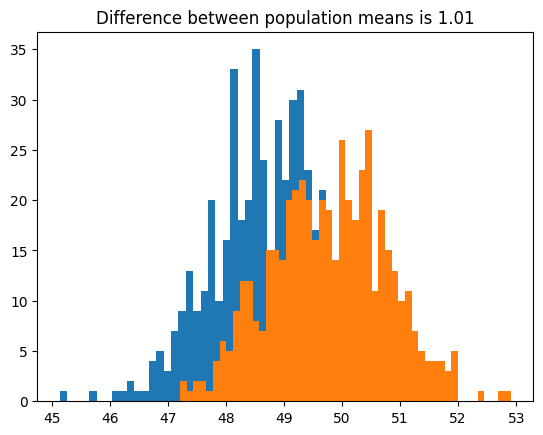

In [22]:
generator = trained_meta_generator()
with torch.no_grad():
    ages_males, ages_females = model(generator)

f, ax = plt.subplots()
ax.hist(ages_males.numpy(), bins=50, label="male")
ax.hist(ages_females.numpy(), bins=50, label="female");
mean_diff = torch.abs(ages_males.mean() - ages_females.mean()).item()
ax.set_title(f"Difference between population means is {mean_diff:.2f}")
f.savefig("../docs/_static/age_example.png", dpi=150, bbox_inches="tight")